In [1]:
import torch
import torch.utils.data as torch_data

import losses
import trainer
from models import UNetGANWrap
from utils import ColorizationDataset, colorfulness_metric
import random
import numpy as np

SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/dfbakin/.cache/pypoetry/virtualenvs/colorizer-C6ZZGchb-py3.12/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import matplotlib.pyplot as plt
import cv2

REQUIRED_SIZE = (256, 256)
combined_dataset = torch_data.ConcatDataset(
    [
        ColorizationDataset("datasets/coco_2017_test", resize=REQUIRED_SIZE, filter_colorless=False),
        ColorizationDataset(
            "datasets/imagenet_classes", resize=REQUIRED_SIZE, classes_folders=True, filter_colorless=False
        ),
    ]
)
print("Length:", len(combined_dataset))

Length: 90670


Lenghths: 89764 453 453
torch.Size([1, 1, 256, 256]) torch.Size([1, 2, 256, 256])
(1, 256, 256, 3)
(1, 256, 256, 3)
26.156716843495467


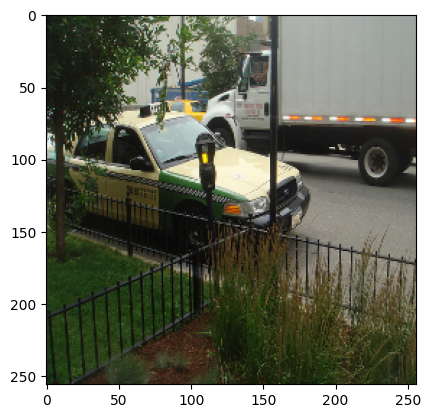

In [3]:
train_dataset, val_dataset, test_dataset = torch_data.random_split(
    combined_dataset, [0.99, 0.005, 0.005]
)  # debug lengths: 2034 407 38229
print("Lenghths:", *[len(item) for item in [train_dataset, val_dataset, test_dataset]])

L, ab = combined_dataset[0]
rgb_img = ColorizationDataset.torch_L_ab_to_cvimage(L.unsqueeze(0), ab.unsqueeze(0)).squeeze(0)
print(colorfulness_metric(rgb_img))
plt.imshow(rgb_img)
plt.show()

In [4]:
batch_size = 8

train_loader = torch_data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=8
)
val_loader = torch_data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=8
)

In [ ]:
from fastai.vision.models import resnet18
from fastai.vision.models.unet import DynamicUnet
import torch.nn as nn
from fastai.vision.learner import create_body

def build_res_unet(n_input=1, n_output=2, size=256, freeze_encoder=True):
    encoder = resnet18(weights="IMAGENET1K_V1")
    layers = [nn.Conv2d(n_input, 3, kernel_size=1)] + list(encoder.children())[:-2]
    encoder = nn.Sequential(*layers)
    
    if freeze_encoder:
        for param in encoder.parameters():
            param.requires_grad = False  # Freeze encoder weights

    net_G = DynamicUnet(encoder, n_output, (size, size), norm_type=None)
    return net_G

In [ ]:
import torch.optim as optim
import torch.nn as nn
from models import UNet
from tqdm import tqdm

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_gen = build_res_unet(n_input=1, n_output=2, size=256, freeze_encoder=False).to(device)
# summary(unet_gen, (1, 256, 256), device=device.type)

criterion = nn.L1Loss()
optimizer = optim.Adam(unet_gen.parameters(), lr=1e-4)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    unet_gen.train()
    running_loss = 0.0
    for L, ab in tqdm(train_loader):
        L = L.to(device)
        ab = ab.to(device)

        # Forward pass
        ab_pred = unet_gen(L)

        # Compute loss
        loss = criterion(ab_pred, ab)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

100%|██████████| 51/51 [00:18<00:00,  2.71it/s]

Epoch [1/1], Loss: 0.1125


In [ ]:
# from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetGANWrap(net_G=unet_gen, device=device)
# summary(model, input_size=(1, *REQUIRED_SIZE))

In [ ]:
baseline_trainer = trainer.Trainer(
    model, train_loader, val_dataloader=val_loader, device=device,
    use_logger=False,
    use_checkpointing=True,
    checkpoit_dir="checkpoints/checkpoints_gan_loss_baseline"
)

In [ ]:
baseline_trainer.train(1)

torch.Size([1, 1, 256, 256]) torch.Size([1, 2, 256, 256])
(1, 256, 256, 3)
(1, 256, 256, 3)
torch.Size([1, 1, 256, 256]) torch.Size([1, 2, 256, 256])
(1, 256, 256, 3)
(1, 256, 256, 3)


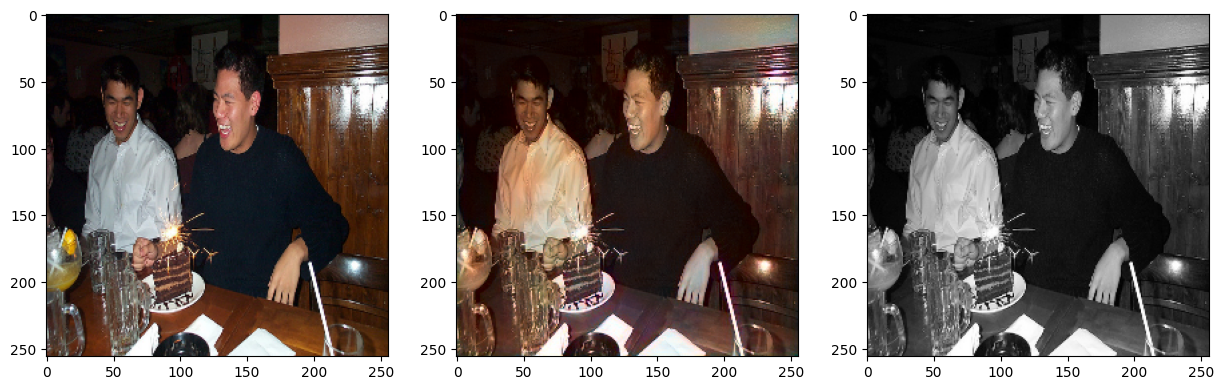

In [30]:
L, ab = val_dataset[105]

L = L.unsqueeze(0)
ab = ab.unsqueeze(0)

cielab_img_gt = ColorizationDataset.torch_L_ab_to_cvimage(L, ab)
model.setup_input([L, ab])
ab_prediction = model.test()["fake_color"]
cielab_img_pred = ColorizationDataset.torch_L_ab_to_cvimage(L, ab_prediction.to("cpu"))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cielab_img_gt.squeeze(0))
ax[1].imshow(cielab_img_pred.squeeze(0))
ax[2].imshow(L.squeeze(0).numpy().transpose(1, 2, 0), cmap="gray")
plt.show()